# dots measurement at Subaru (20211014 on-telecope) (for all visits)

In [1]:
%matplotlib notebook

import pandas as pd
import sep
import cv2
from copy import deepcopy

import os
import sys
import numpy as np
import astropy.io.fits as pyfits
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy import ndimage as nd

In [2]:
data_dir = '/work/PFS/pfi/data/erun03/2021-09-26'
repo_dir = '/work/PFS/repo/pfs_instdata'
ff_data_dir = '/work/PFS/pfi/data/ffdata'

## function for the dot measurement

In [3]:
def get_dot_position(data, rx, ry, angle, reg1, thresh1, reg2, thresh2):

    ## data region trimming (1st pass) ##
    reg=reg1
    v_med =  np.nanmedian(data)
    imag_new = np.zeros(data.shape)
    for xd, yd in zip(rx, ry):
        try:
            x1 = int(xd - reg)
            x2 = int(xd + reg)
            y1 = int(yd - reg)
            y2 = int(yd + reg)
            v_med = np.median(data[y1-reg:y2+reg, x1-reg:x2+reg])
            imag_new[y1:y2, x1:x2] = data[y1:y2, x1:x2] - v_med
        except:
            pass

    ## get dot positions (1st pass) ##
    print(f'running 1st pass ...')
    reg=reg1
    bad_idx = []
    dot_pos = []
    for i in range(len(rx)):
        data_sub=imag_new[int(ry[i]-reg):int(ry[i]+reg),int(rx[i]-reg):int(rx[i]+reg)]
        imag_sub=deepcopy(data_sub)
        imag_sub = 255 * imag_sub / imag_sub.max()
        circles = cv2.HoughCircles(imag_sub.astype('uint8'), cv2.HOUGH_GRADIENT, 1, 50,
                                   param1=100,param2=5,minRadius=7,maxRadius=10)
        if circles is not None:
            dot_x = int(rx[i]-reg)+circles[0,0,0]
            dot_y = int(ry[i]-reg)+circles[0,0,1]
            dot_r = circles[0,0,2]
            dot_pos.append((dot_x, dot_y, dot_r))
        else:
            bad_idx.append(i)
            dot_pos.append((np.nan, np.nan, np.nan))
            print(f' dota id {i} at {rx[i]} {ry[i]} detection failed')
    dot_pos = np.array(dot_pos) 
    
    ## transformation (1st pass) ##
    pts0=np.zeros((1,len(fel),3))
    pts0[0,:,0]=fel['x_mm']
    pts0[0,:,1]=fel['y_mm']
    pts0[0,:,2]=[0 for x in fel['x_mm']]
    pts1=np.zeros((1,len(fel),3))
    pts2=np.zeros((1,len(fel),2))
    pts1[0,:,0]=fel['x_mm']
    pts1[0,:,1]=fel['y_mm']
    pts1[0,:,2]=[0 for x in fel['x_mm']]
    pts2[0,:,0]=dot_pos[:,0]
    pts2[0,:,1]=dot_pos[:,1]
    pts1 = np.float32(pts1)
    pts2 = np.float32(pts2)
    for i in np.sort(bad_idx)[::-1]:
        pts1 = np.delete(pts1, i, 1)
        pts2 = np.delete(pts2, i, 1)    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(pts1, pts2, data.shape[::-1], None, None)    
    imgpoints2, _ = cv2.projectPoints(pts0[0].astype(np.float32),rvecs[0], tvecs[0], mtx, dist)
    dot_pos_new = np.float32([[x,y,r] for x,y,r in zip(imgpoints2[:,0,0], imgpoints2[:,0,1], dot_pos[:,2])])
    
    ## data region trimming (2nd pass) ##
    rx2 = dot_pos_new[:,0]
    ry2 = dot_pos_new[:,1]   
    reg=reg2
    v_med =  np.nanmedian(data)
    imag_new2 = np.zeros(data.shape)
    for xd, yd in zip(rx2, ry2):
        try:
            x1 = int(xd - reg)
            x2 = int(xd + reg)
            y1 = int(yd - reg)
            y2 = int(yd + reg)
            v_med = np.median(data[y1-reg:y2+reg, x1-reg:x2+reg])
            imag_new2[y1:y2, x1:x2] = data[y1:y2, x1:x2] - v_med
        except:
            pass

    ## get dot positions (2nd pass) ##
    print(f'running 2nd pass ...')
    reg=reg2
    bad_idx = []
    dot_pos2 = []
    for i in range(len(rx2)):
        data_sub=imag_new2[int(ry2[i]-reg):int(ry2[i]+reg),int(rx2[i]-reg):int(rx2[i]+reg)]
        imag_sub=deepcopy(data_sub)
        imag_sub = 255 * imag_sub / imag_sub.max()
        circles = cv2.HoughCircles(imag_sub.astype('uint8'), cv2.HOUGH_GRADIENT, 1, 50,
                                   param1=100,param2=5,minRadius=7,maxRadius=10)
        if circles is not None:
            dot_x = int(rx2[i]-reg) + circles[0,0,0]
            dot_y = int(ry2[i]-reg) + circles[0,0,1]
            dot_r = circles[0,0,2]
            dot_pos2.append((dot_x, dot_y, dot_r))
        else:
            bad_idx.append(i)
            dot_pos2.append((np.nan, np.nan, np.nan))
            print(f' dota id {i} at {rx[i]} {ry[i]} detection failed')
    dot_pos2 = np.array(dot_pos2)    

    ## transformation (2nd pass) ##
    pts0=np.zeros((1,len(fel),3))
    pts0[0,:,0]=fel['x_mm']
    pts0[0,:,1]=fel['y_mm']
    pts0[0,:,2]=[0 for x in fel['x_mm']]
    pts1=np.zeros((1,len(fel),3))
    pts2=np.zeros((1,len(fel),2))
    pts1[0,:,0]=fel['x_mm']
    pts1[0,:,1]=fel['y_mm']
    pts1[0,:,2]=[0 for x in fel['x_mm']]
    pts2[0,:,0]=dot_pos2[:,0]
    pts2[0,:,1]=dot_pos2[:,1]
    pts1 = np.float32(pts1)
    pts2 = np.float32(pts2)
    for i in np.sort(bad_idx)[::-1]:
        pts1 = np.delete(pts1, i, 1)
        pts2 = np.delete(pts2, i, 1)    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(pts1, pts2, data.shape[::-1], None, None)    
    ## calculate dot center ##
    imgpoints2, _ = cv2.projectPoints(pts0[0].astype(np.float32),rvecs[0], tvecs[0], mtx, dist)
    ## calculate dot radius ##
    pts0d = deepcopy(pts0)
    pts0d[0,:,0] = pts0d[0,:,0] + 1.5
    tmp1, _ = cv2.projectPoints(pts0[0].astype(np.float32),rvecs[0], tvecs[0], mtx, dist)
    tmp2, _ = cv2.projectPoints(pts0d[0].astype(np.float32),rvecs[0], tvecs[0], mtx, dist)
    dot_rad = (tmp1[:,0,1] - tmp2[:,0,1]) / 2.0
    dot_pos_new2 = np.float32([[x,y,r] for x,y,r in zip(imgpoints2[:,0,0], imgpoints2[:,0,1], dot_rad[:])])       
    return dot_pos2, dot_pos_new2

## get designed dots information

In [4]:
filename = os.path.join(repo_dir, 'data/pfi/dot',
                        'dot_design_asrd_20210422.txt')
fel = pd.read_csv(filename,
                  delim_whitespace=True,
                  header=None,
                  names=['id', 'x_mm', 'y_mm', 'x', 'y', 'bb', 'cc']
                 )
fel[:3]

id        x_mm  y_mm            x            y           bb           cc
0   0   96.994843   0.0  5614.759176  2886.225955  5614.759277  2886.101562
1   1  103.923042   4.0  5695.685201  2932.765529  5695.393555  2932.880127
2   2  110.851250   8.0  5776.593112  2979.286068  5776.393066  2979.337891

## measure dot positions

### rot angle = 0 deg., EL=90 deg.

In [5]:
filename = 'black_dots_mcs_pix_rough_position_20211108.csv'
dots_mcs_rough = pd.read_csv(filename)
rx = dots_mcs_rough['x']
ry = dots_mcs_rough['y']
dots_mcs_rough[:3]

dotId          x          y    r
0      0  4490.5220  2786.7947  8.9
1      1  4443.3780  2704.5344  8.9
2      2  4396.2334  2622.2979  8.9

In [6]:
visit = 68840

print('visit=%d' % (visit))
## get data ##
filename = os.path.join(data_dir, 'PFSC%06d00.fits' % (visit))
with pyfits.open(filename) as f:
    data = f[1].data
## median filtering ##
data_med = nd.median_filter(data, size=3)
## measurement ##
dot_pos2, dot_pos_new2 = get_dot_position(data_med,
                                          rx,
                                          ry,
                                          angle=0.0,
                                          reg1=15,
                                          thresh1=3000,
                                          reg2=15,
                                          thresh2=3000)
## writeto ##
dot_id = np.arange(len(dot_pos2))
dat = [[i, p1[0], p1[1], p1[2], p2[0], p2[1], p2[2]]
       for i, p1, p2 in zip(dot_id, dot_pos2, dot_pos_new2)]
filename = './results/dot_measurements_subaru_20210926_el90_rot+00_v%d.csv' % (
    visit)
np.savetxt(filename,
           dat,
           delimiter=',',
           header='id,x_meas,y_meas,r_meas,x_tran,y_tran,r_tran',
           comments='')

visit=68840
running 1st pass ...
running 2nd pass ...


    id  x_meas  y_meas  r_meas       x_tran       y_tran    r_tran
0  0.0  4490.5  2783.5     8.2  4489.355469  2787.317139  8.880127
1  1.0  4448.5  2704.5     9.4  4442.237305  2705.149170  8.878540
2  2.0  4398.5  2621.5     8.2  4395.125488  2623.004150  8.875732


<IPython.core.display.Javascript object>


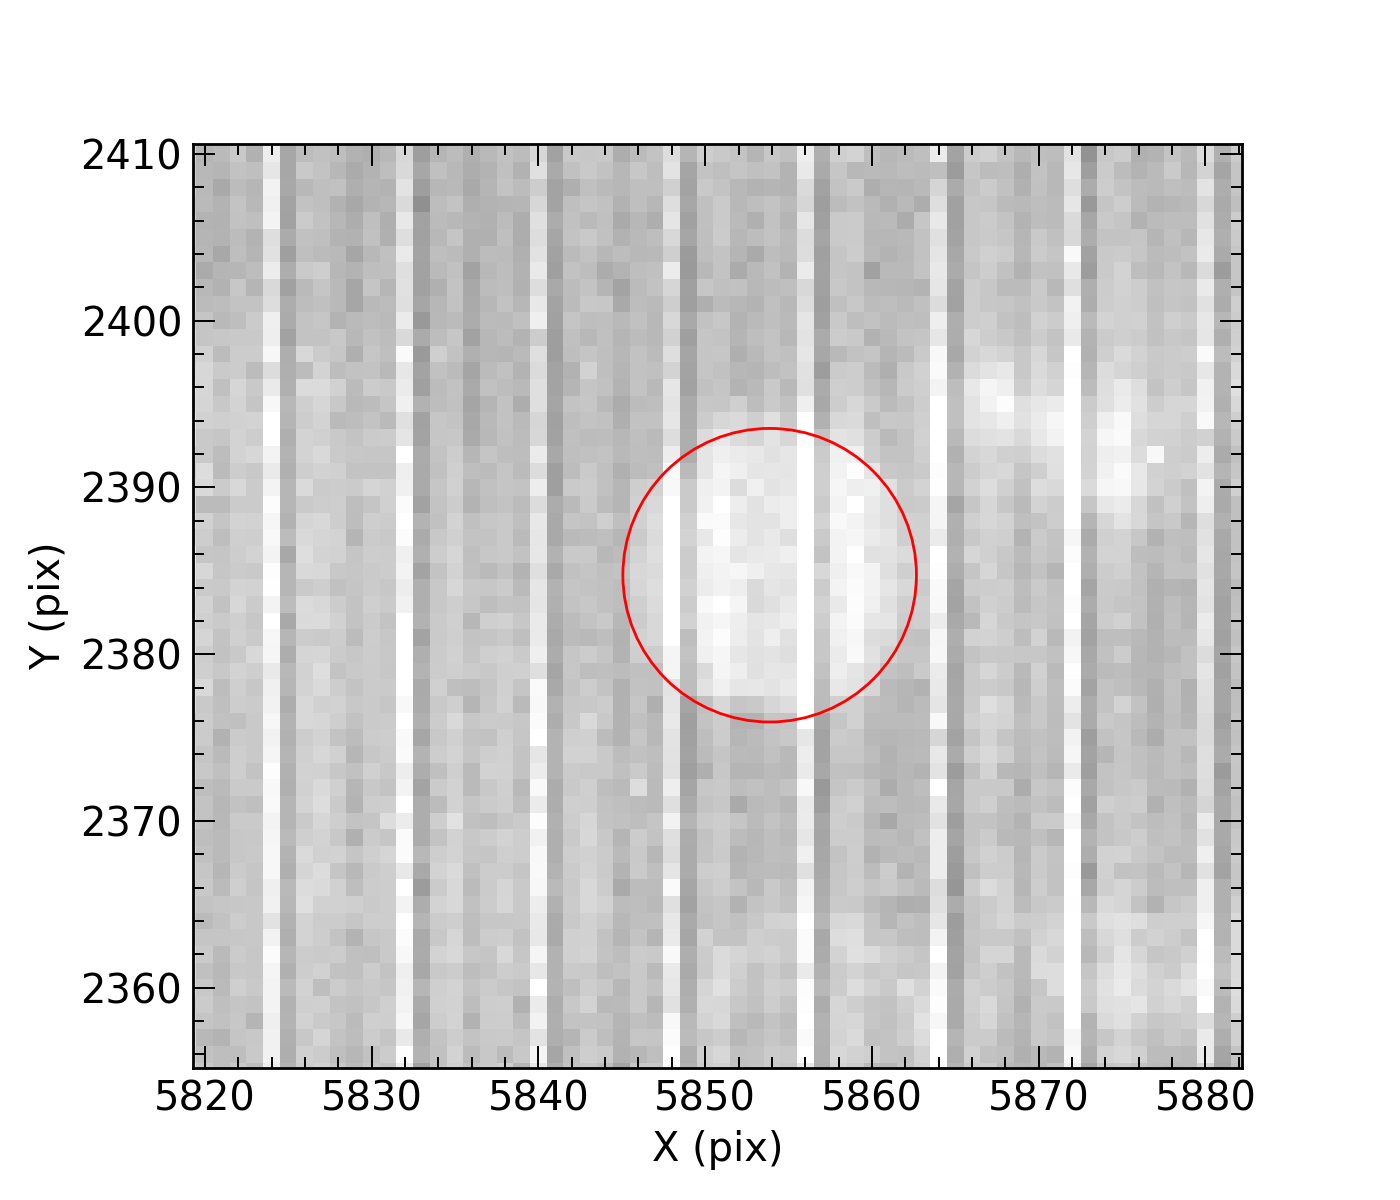

In [7]:
filename = './results/dot_measurements_subaru_20210926_el90_rot+00_v%d.csv' % (visit)
df = pd.read_csv(filename)
print(df[:3])

## check distribution
fig, axe = plt.subplots(figsize=(7, 6))
axe.set_aspect('equal')
axe.set_xlabel(r'X (pix)')
axe.set_ylabel(r'Y (pix)')
axe.set_title(r'')
axe.imshow(data, origin='lower', cmap='gray', vmin=38000, vmax=39500)
for x,y,r in zip(df['x_tran'], df['y_tran'], df['r_tran']):
    c1 = plt.Circle((x,y), r, color='red', fill=False)
    axe.add_artist(c1)

### rot angle = 0 deg., EL=75 deg.

In [8]:
filename = './results/dot_measurements_subaru_20210926_el90_rot+00_v68840.csv'
dots_mcs_rough = pd.read_csv(filename)
rx = dots_mcs_rough['x_tran']
ry = dots_mcs_rough['y_tran']
dots_mcs_rough[:3]

id  x_meas  y_meas  r_meas       x_tran       y_tran    r_tran
0  0.0  4490.5  2783.5     8.2  4489.355469  2787.317139  8.880127
1  1.0  4448.5  2704.5     9.4  4442.237305  2705.149170  8.878540
2  2.0  4398.5  2621.5     8.2  4395.125488  2623.004150  8.875732

In [9]:
visit = 68839

print('visit=%d' % (visit))
## get data ##
filename = os.path.join(data_dir, 'PFSC%06d00.fits' % (visit))
with pyfits.open(filename) as f:
    data = f[1].data
## median filtering ##
data_med = nd.median_filter(data, size=3)
## measurement ##
dot_pos2, dot_pos_new2 = get_dot_position(data_med,
                                          rx,
                                          ry,
                                          angle=0.0,
                                          reg1=15,
                                          thresh1=3000,
                                          reg2=15,
                                          thresh2=3000)
## writeto ##
dot_id = np.arange(len(dot_pos2))
dat = [[i, p1[0], p1[1], p1[2], p2[0], p2[1], p2[2]]
       for i, p1, p2 in zip(dot_id, dot_pos2, dot_pos_new2)]
filename = './results/dot_measurements_subaru_20210926_el75_rot+00_v%d.csv' % (
    visit)
np.savetxt(filename,
           dat,
           delimiter=',',
           header='id,x_meas,y_meas,r_meas,x_tran,y_tran,r_tran',
           comments='')

visit=68839
running 1st pass ...
running 2nd pass ...


    id  x_meas  y_meas  r_meas       x_tran       y_tran    r_tran
0  0.0  4492.5  2786.5     9.3  4486.949707  2786.065430  8.875732
1  1.0  4443.5  2701.5     9.4  4439.856934  2703.945068  8.872437
2  2.0  4388.5  2627.5     9.4  4392.781250  2621.865234  8.867676


<IPython.core.display.Javascript object>


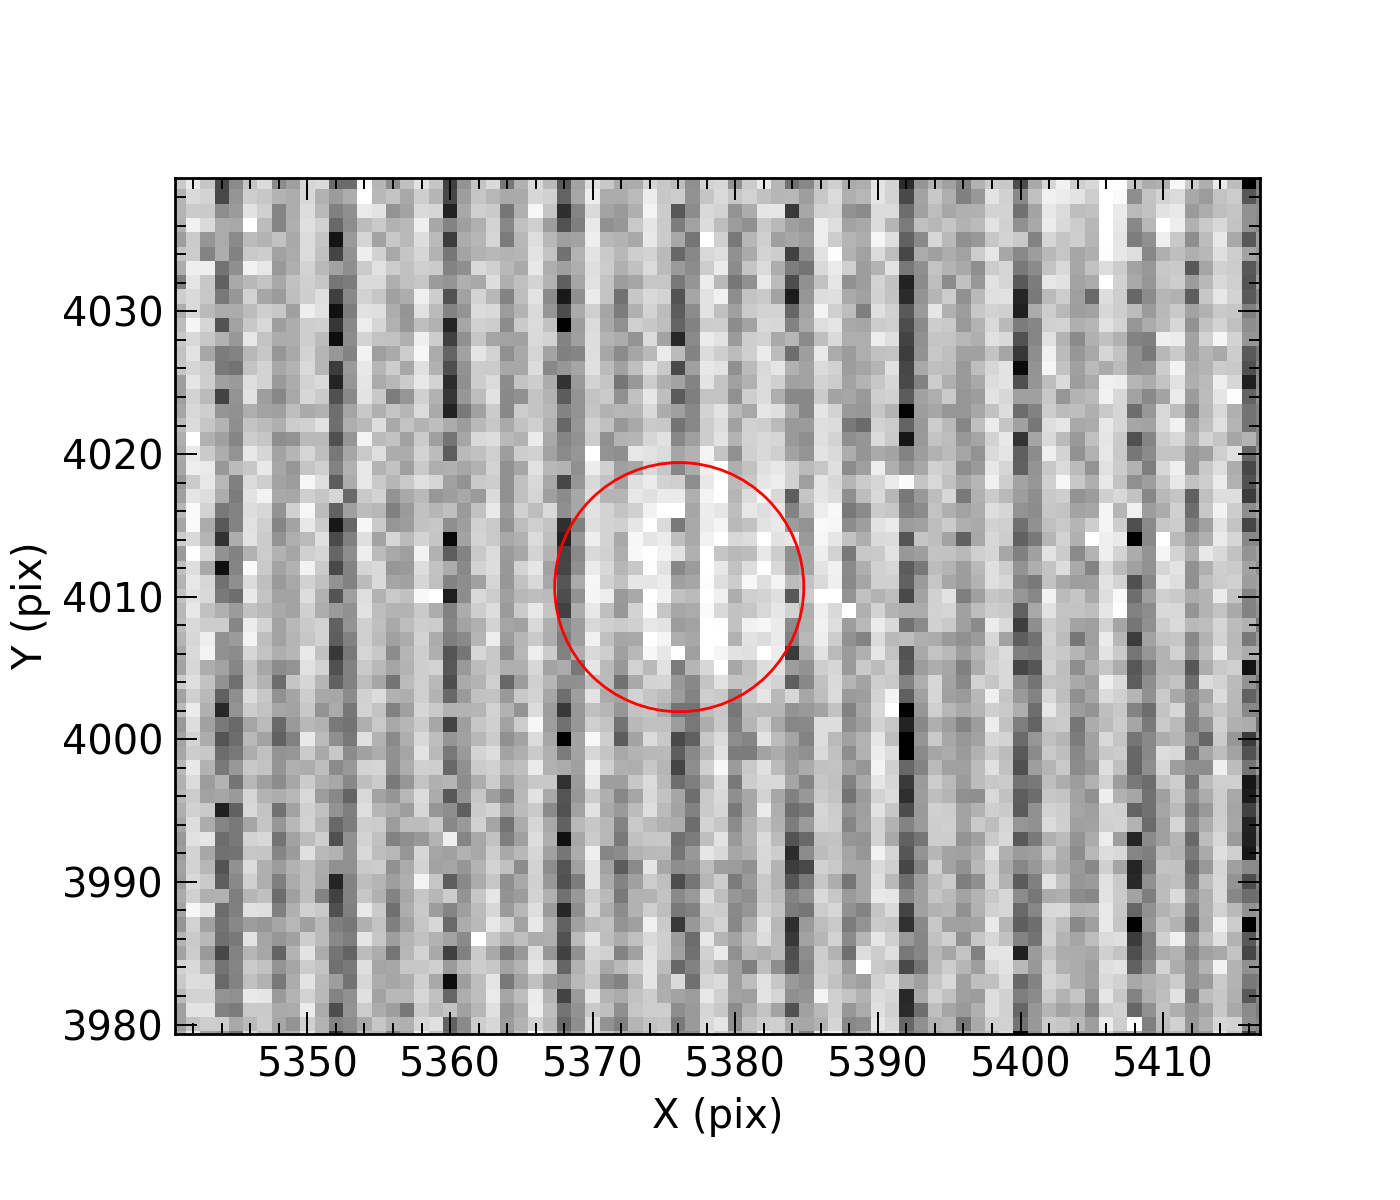

In [10]:
filename = './results/dot_measurements_subaru_20210926_el75_rot+00_v%d.csv' % (visit)
df = pd.read_csv(filename)
print(df[:3])

## check distribution
fig, axe = plt.subplots(figsize=(7, 6))
axe.set_aspect('equal')
axe.set_xlabel(r'X (pix)')
axe.set_ylabel(r'Y (pix)')
axe.set_title(r'')
axe.imshow(data, origin='lower', cmap='gray', vmin=38500, vmax=39000)
for x,y,r in zip(df['x_tran'], df['y_tran'], df['r_tran']):
    c1 = plt.Circle((x,y), r, color='red', fill=False)
    axe.add_artist(c1)

### rot angle = 0 deg., EL=60 deg.

In [11]:
filename = './results/dot_measurements_subaru_20210926_el90_rot+00_v68840.csv'
dots_mcs_rough = pd.read_csv(filename)
rx = dots_mcs_rough['x_tran']
ry = dots_mcs_rough['y_tran']
dots_mcs_rough[:3]

id  x_meas  y_meas  r_meas       x_tran       y_tran    r_tran
0  0.0  4490.5  2783.5     8.2  4489.355469  2787.317139  8.880127
1  1.0  4448.5  2704.5     9.4  4442.237305  2705.149170  8.878540
2  2.0  4398.5  2621.5     8.2  4395.125488  2623.004150  8.875732

In [12]:
visit = 68836

print('visit=%d' % (visit))
## get data ##
filename = os.path.join(data_dir, 'PFSC%06d00.fits' % (visit))
with pyfits.open(filename) as f:
    data = f[1].data
## median filtering ##
data_med = nd.median_filter(data, size=3)
## measurement ##
dot_pos2, dot_pos_new2 = get_dot_position(data_med,
                                          rx,
                                          ry,
                                          angle=0.0,
                                          reg1=20,
                                          thresh1=3000,
                                          reg2=20,
                                          thresh2=3000)
## writeto ##
dot_id = np.arange(len(dot_pos2))
dat = [[i, p1[0], p1[1], p1[2], p2[0], p2[1], p2[2]]
       for i, p1, p2 in zip(dot_id, dot_pos2, dot_pos_new2)]
filename = './results/dot_measurements_subaru_20210926_el60_rot+00_v%d.csv' % (
    visit)
np.savetxt(filename,
           dat,
           delimiter=',',
           header='id,x_meas,y_meas,r_meas,x_tran,y_tran,r_tran',
           comments='')

visit=68836
running 1st pass ...
running 2nd pass ...


    id  x_meas  y_meas  r_meas       x_tran       y_tran    r_tran
0  0.0  4485.5  2798.5     8.2  4485.360352  2786.152344  8.875977
1  1.0  4439.5  2703.5     8.2  4438.271973  2704.030762  8.874023
2  2.0  4394.5  2619.5     9.4  4391.201172  2621.938232  8.870850


<IPython.core.display.Javascript object>


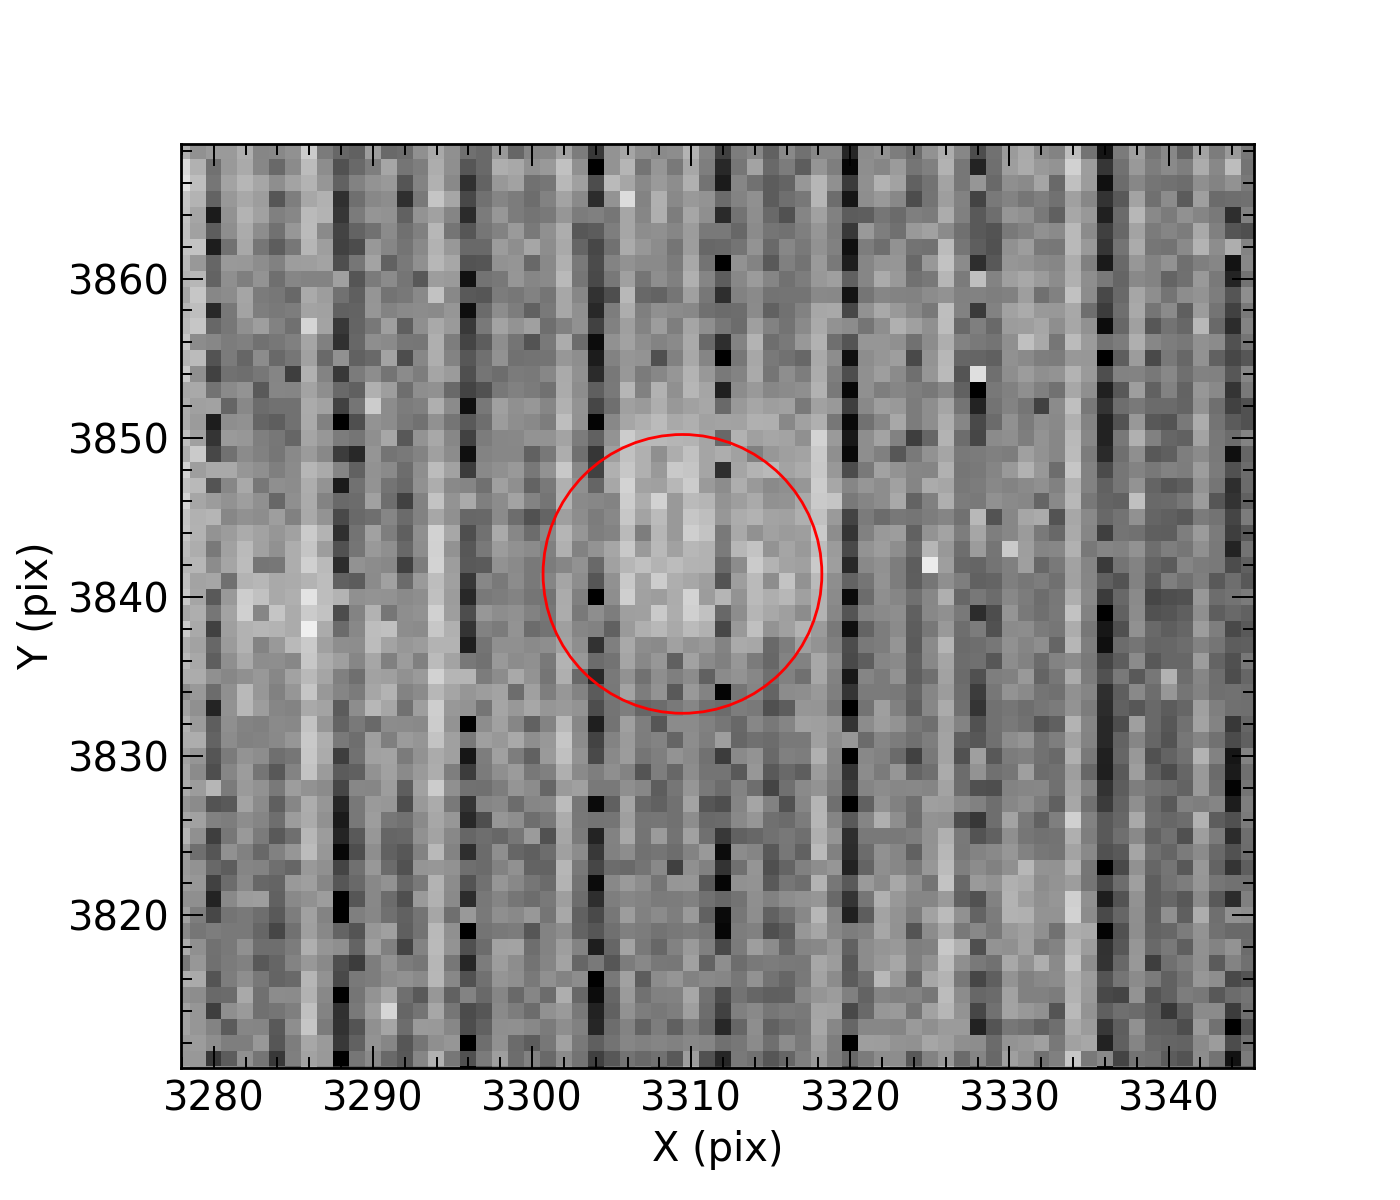

In [13]:
filename = './results/dot_measurements_subaru_20210926_el60_rot+00_v%d.csv' % (visit)
df = pd.read_csv(filename)
print(df[:3])

## check distribution
fig, axe = plt.subplots(figsize=(7, 6))
axe.set_aspect('equal')
axe.set_xlabel(r'X (pix)')
axe.set_ylabel(r'Y (pix)')
axe.set_title(r'')
axe.imshow(data, origin='lower', cmap='gray', vmin=38500, vmax=39000)
for x,y,r in zip(df['x_tran'], df['y_tran'], df['r_tran']):
    c1 = plt.Circle((x,y), r, color='red', fill=False)
    axe.add_artist(c1)

### rot angle = 0 deg., EL=45 deg.

In [18]:
filename = './results/dot_measurements_subaru_20210926_el90_rot+00_v68840.csv'
dots_mcs_rough = pd.read_csv(filename)
rx = dots_mcs_rough['x_tran'] - 30
ry = dots_mcs_rough['y_tran']
dots_mcs_rough[:3]

id  x_meas  y_meas  r_meas       x_tran       y_tran    r_tran
0  0.0  4490.5  2783.5     8.2  4489.355469  2787.317139  8.880127
1  1.0  4448.5  2704.5     9.4  4442.237305  2705.149170  8.878540
2  2.0  4398.5  2621.5     8.2  4395.125488  2623.004150  8.875732

In [19]:
visit = 68832

print('visit=%d' % (visit))
## get data ##
filename = os.path.join(data_dir, 'PFSC%06d00.fits' % (visit))
with pyfits.open(filename) as f:
    data = f[1].data
## median filtering ##
data_med = nd.median_filter(data, size=3)
## measurement ##
dot_pos2, dot_pos_new2 = get_dot_position(data_med,
                                          rx,
                                          ry,
                                          angle=0.0,
                                          reg1=20,
                                          thresh1=3000,
                                          reg2=20,
                                          thresh2=3000)
## writeto ##
dot_id = np.arange(len(dot_pos2))
dat = [[i, p1[0], p1[1], p1[2], p2[0], p2[1], p2[2]]
       for i, p1, p2 in zip(dot_id, dot_pos2, dot_pos_new2)]
filename = './results/dot_measurements_subaru_20210926_el45_rot+00_v%d.csv' % (
    visit)
np.savetxt(filename,
           dat,
           delimiter=',',
           header='id,x_meas,y_meas,r_meas,x_tran,y_tran,r_tran',
           comments='')

visit=68832
running 1st pass ...
running 2nd pass ...


    id  x_meas  y_meas  r_meas       x_tran       y_tran    r_tran
0  0.0  4446.5  2782.5     9.4  4454.905273  2783.787109  8.886353
1  1.0  4402.5  2711.5     9.4  4407.729980  2701.547363  8.884277
2  2.0  4352.5  2614.5     9.4  4360.565430  2619.336670  8.880615


<IPython.core.display.Javascript object>


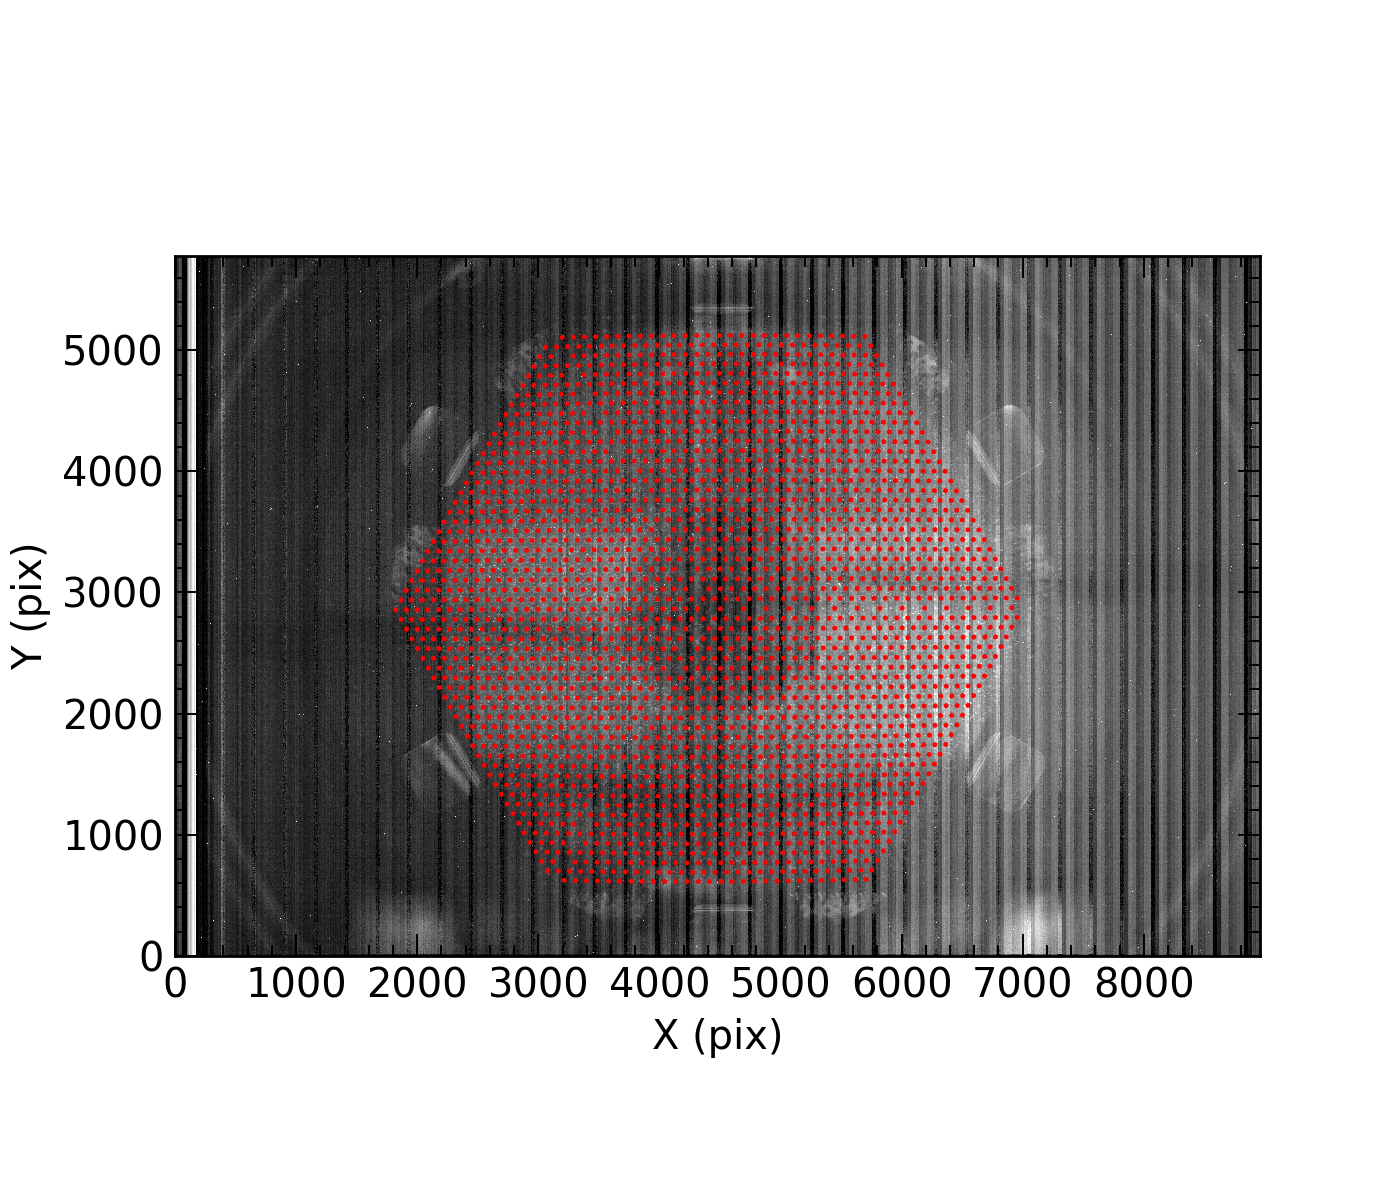

In [20]:
filename = './results/dot_measurements_subaru_20210926_el45_rot+00_v%d.csv' % (visit)
df = pd.read_csv(filename)
print(df[:3])

## check distribution
fig, axe = plt.subplots(figsize=(7, 6))
axe.set_aspect('equal')
axe.set_xlabel(r'X (pix)')
axe.set_ylabel(r'Y (pix)')
axe.set_title(r'')
axe.imshow(data, origin='lower', cmap='gray', vmin=38500, vmax=39500)
for x,y,r in zip(df['x_tran'], df['y_tran'], df['r_tran']):
    c1 = plt.Circle((x,y), r, color='red', fill=False)
    axe.add_artist(c1)

### rot angle = 0 deg., EL=30 deg.

In [21]:
filename = './results/dot_measurements_subaru_20210926_el90_rot+00_v68840.csv'
dots_mcs_rough = pd.read_csv(filename)
rx = dots_mcs_rough['x_tran']
ry = dots_mcs_rough['y_tran']-8
dots_mcs_rough[:3]

id  x_meas  y_meas  r_meas       x_tran       y_tran    r_tran
0  0.0  4490.5  2783.5     8.2  4489.355469  2787.317139  8.880127
1  1.0  4448.5  2704.5     9.4  4442.237305  2705.149170  8.878540
2  2.0  4398.5  2621.5     8.2  4395.125488  2623.004150  8.875732

In [22]:
visit = 68835

print('visit=%d' % (visit))
## get data ##
filename = os.path.join(data_dir, 'PFSC%06d00.fits' % (visit))
with pyfits.open(filename) as f:
    data = f[1].data
## median filtering ##
data_med = nd.median_filter(data, size=3)
## measurement ##
dot_pos2, dot_pos_new2 = get_dot_position(data_med,
                                          rx,
                                          ry,
                                          angle=0.0,
                                          reg1=20,
                                          thresh1=3000,
                                          reg2=20,
                                          thresh2=3000)
## writeto ##
dot_id = np.arange(len(dot_pos2))
dat = [[i, p1[0], p1[1], p1[2], p2[0], p2[1], p2[2]]
       for i, p1, p2 in zip(dot_id, dot_pos2, dot_pos_new2)]
filename = './results/dot_measurements_subaru_20210926_el30_rot+00_v%d.csv' % (
    visit)
np.savetxt(filename,
           dat,
           delimiter=',',
           header='id,x_meas,y_meas,r_meas,x_tran,y_tran,r_tran',
           comments='')

visit=68835
running 1st pass ...
running 2nd pass ...


    id  x_meas  y_meas  r_meas       x_tran       y_tran    r_tran
0  0.0  4486.5  2787.5     9.4  4485.926270  2777.532227  8.885132
1  1.0  4436.5  2691.5     9.4  4438.767578  2695.320068  8.882935
2  2.0  4392.5  2611.5     8.2  4391.620117  2613.137695  8.879395


<IPython.core.display.Javascript object>


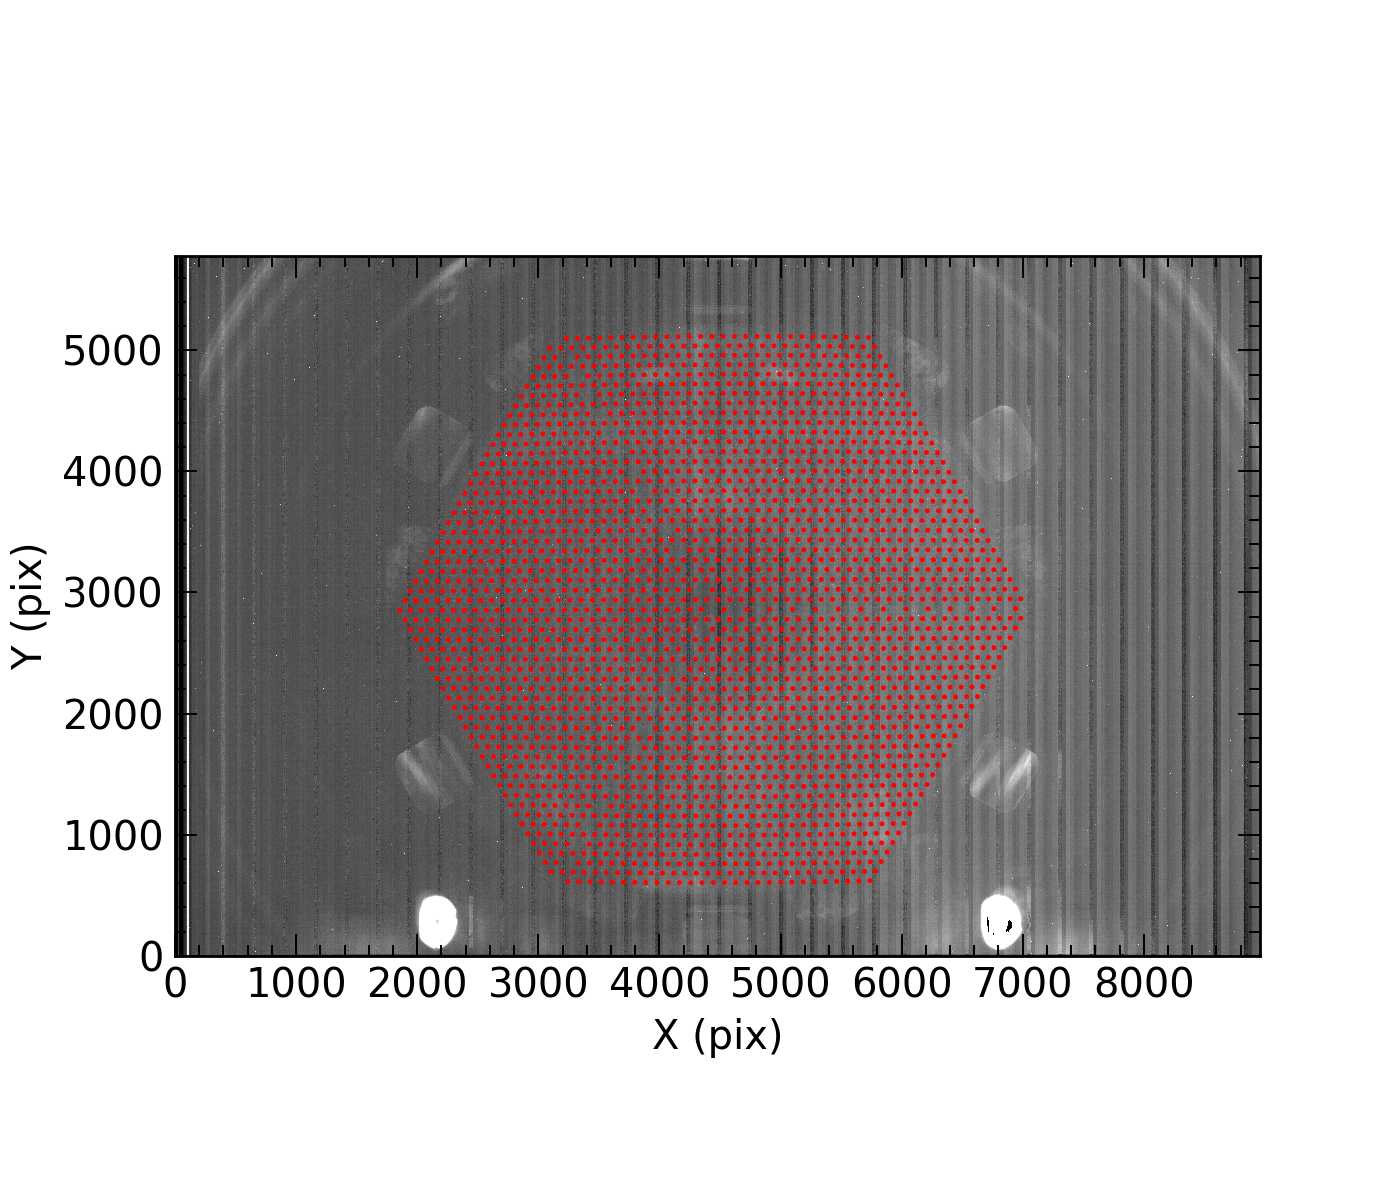

In [23]:
filename = './results/dot_measurements_subaru_20210926_el30_rot+00_v%d.csv' % (visit)
df = pd.read_csv(filename)
print(df[:3])

## check distribution
fig, axe = plt.subplots(figsize=(7, 6))
axe.set_aspect('equal')
axe.set_xlabel(r'X (pix)')
axe.set_ylabel(r'Y (pix)')
axe.set_title(r'')
axe.imshow(data, origin='lower', cmap='gray', vmin=38000, vmax=40000)
for x,y,r in zip(df['x_tran'], df['y_tran'], df['r_tran']):
    c1 = plt.Circle((x,y), r, color='red', fill=False)
    axe.add_artist(c1)

## plot elevation dependency

In [24]:
filename = './results/dot_measurements_subaru_20210926_el90_rot+00_v68840.csv'
df1 = pd.read_csv(filename)
filename = './results/dot_measurements_subaru_20210926_el75_rot+00_v68839.csv'
df2 = pd.read_csv(filename)
filename = './results/dot_measurements_subaru_20210926_el60_rot+00_v68836.csv'
df3 = pd.read_csv(filename)
filename = './results/dot_measurements_subaru_20210926_el30_rot+00_v68835.csv'
df4 = pd.read_csv(filename)

<IPython.core.display.Javascript object>


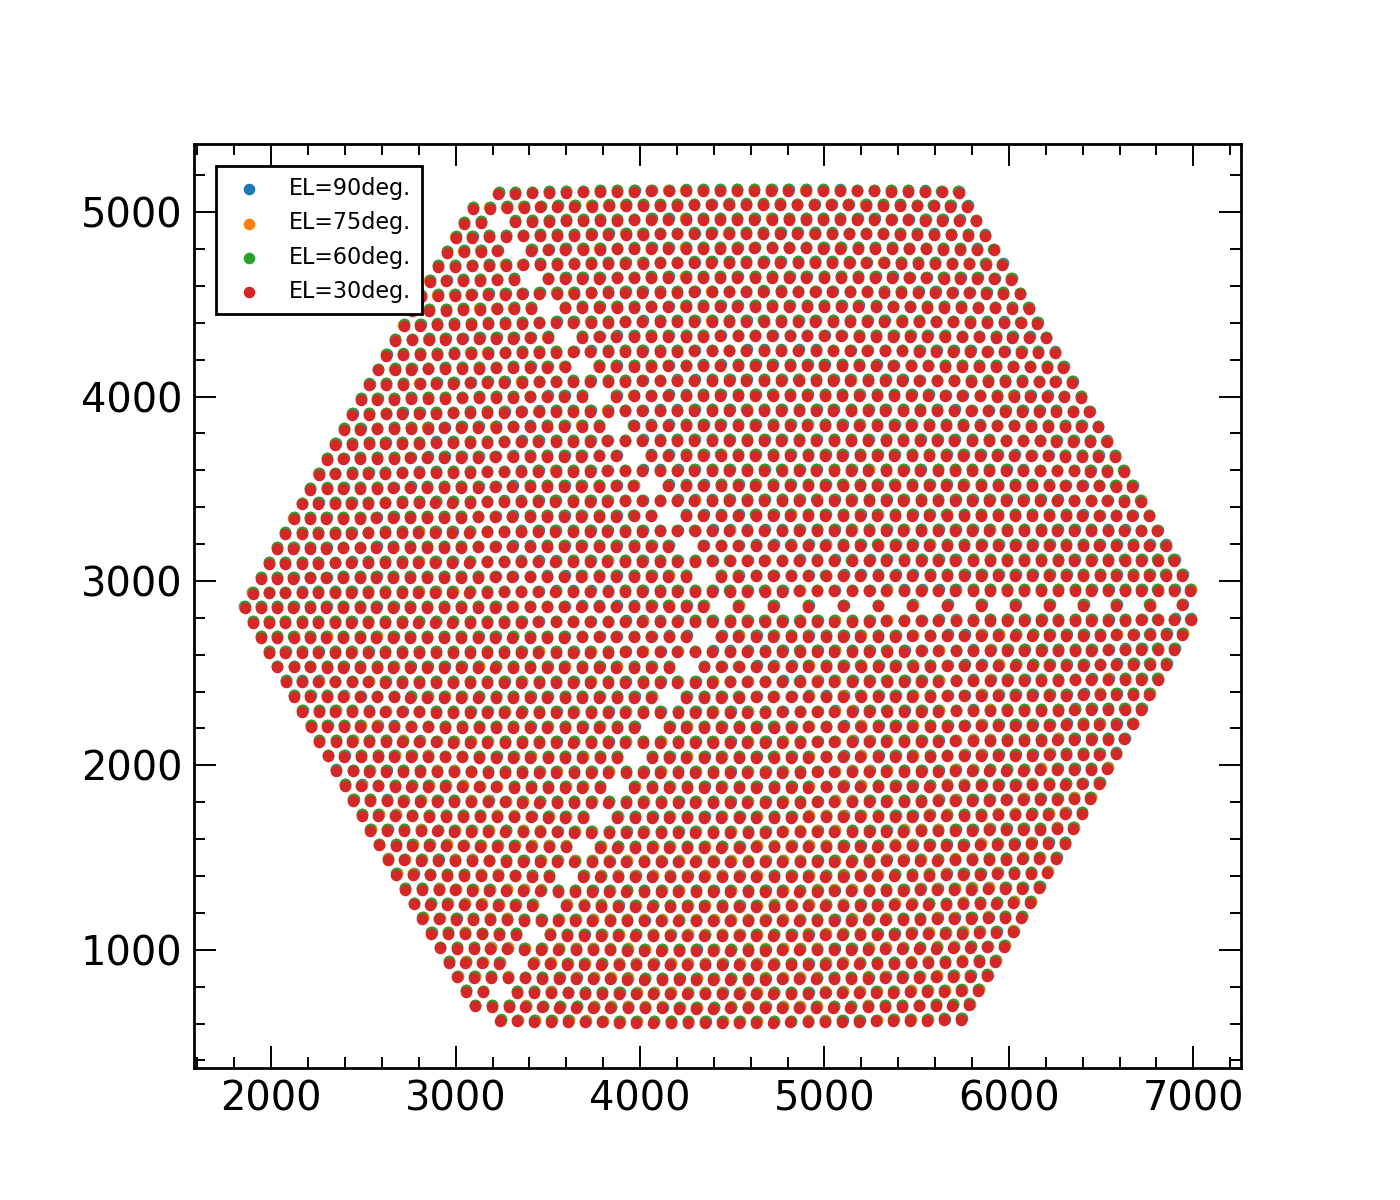

In [25]:
fig, axe = plt.subplots(figsize=(7,6))
axe.set_aspect('equal')
axe.scatter(df1['x_tran'], df1['y_tran'], s=10, label='EL=90deg.')
axe.scatter(df2['x_tran'], df2['y_tran'], s=10, label='EL=75deg.')
axe.scatter(df3['x_tran'], df3['y_tran'], s=10, label='EL=60deg.')
axe.scatter(df4['x_tran'], df4['y_tran'], s=10, label='EL=30deg.')
axe.legend(loc='upper left', fontsize=8)
plt.show()